In [1]:
import pathlib

# Load training data 
img_dir = pathlib.Path("./data/train/")

filelist = sorted([str(path) for path in img_dir.glob("*.jpg")])

Obtaining first 10 images from the dogs and cats dataset

In [2]:
import random

def shuffle_slice(a, start, stop):
    i = start
    while (i < stop-1):
        idx = random.randrange(i, stop)
        a[i], a[idx] = a[idx], a[i]
        i += 1

In [3]:
shuffled_list= shuffle_slice(filelist,1,1000)
filelist

['data/train/cat.0.jpg',
 'data/train/cat.1023.jpg',
 'data/train/cat.10621.jpg',
 'data/train/cat.10440.jpg',
 'data/train/cat.10673.jpg',
 'data/train/cat.10762.jpg',
 'data/train/cat.1057.jpg',
 'data/train/cat.10379.jpg',
 'data/train/cat.10745.jpg',
 'data/train/cat.10295.jpg',
 'data/train/cat.10370.jpg',
 'data/train/cat.10298.jpg',
 'data/train/cat.10829.jpg',
 'data/train/cat.105.jpg',
 'data/train/cat.10318.jpg',
 'data/train/cat.10719.jpg',
 'data/train/cat.100.jpg',
 'data/train/cat.10716.jpg',
 'data/train/cat.10314.jpg',
 'data/train/cat.10524.jpg',
 'data/train/cat.1035.jpg',
 'data/train/cat.10694.jpg',
 'data/train/cat.10248.jpg',
 'data/train/cat.10503.jpg',
 'data/train/cat.10622.jpg',
 'data/train/cat.10430.jpg',
 'data/train/cat.10508.jpg',
 'data/train/cat.10435.jpg',
 'data/train/cat.10349.jpg',
 'data/train/cat.10097.jpg',
 'data/train/cat.10581.jpg',
 'data/train/cat.10312.jpg',
 'data/train/cat.1015.jpg',
 'data/train/cat.10175.jpg',
 'data/train/cat.10501.jpg

Image shape , (374, 500, 3)
Image shape , (315, 349, 3)
Image shape , (499, 375, 3)
Image shape , (299, 400, 3)
Image shape , (239, 320, 3)
Image shape , (347, 479, 3)
Image shape , (499, 375, 3)
Image shape , (374, 500, 3)
Image shape , (388, 500, 3)
Image shape , (376, 418, 3)


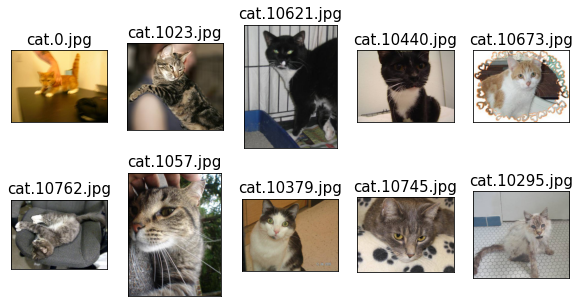

In [4]:
import matplotlib.pyplot as plt
from random import shuffle
import os 
from PIL import Image
import numpy as np

fig = plt.figure(figsize=(10,5))

for i,file in enumerate(filelist[:10]):
    img = Image.open(file)
    print(f"Image shape , {np.array(img).shape}")
    ax = fig.add_subplot(2,5,i+1)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.imshow(img)
    ax.set_title(os.path.basename(file),size=15)

In [5]:
#labels = list(filter(lambda file: True if  ('Dog' in os.path.basename(file) for file in filelist) else False,file))
#print(labels)


labels = [1 if 'dog' in os.path.basename(file) else 0
          for file in filelist]

print(labels[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
import pandas as pd
df_labels = pd.DataFrame([labels])


Creating the base ImageDataset Class

In [7]:
from torch.utils.data import Dataset


class ImageDataset(Dataset):
    def __init__(self,filelist,labels):
        self.filelist = filelist
        self.labels = labels
    
    def __getitem__(self,idx):
        file = self.filelist[idx]
        label = self.labels[idx]
        return file,label
        
    def __len__(self):
        return len(self.labels)    
    
    
image_dataset = ImageDataset(filelist,labels)

#for file,label in image_dataset:
#    print(file,label)

/home/elegant00/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print(image_dataset.__len__)

<bound method ImageDataset.__len__ of <__main__.ImageDataset object at 0x7f521e671900>>


Applying `transforms` to the dataset, we load the image content from its file path and decode its raw content ,to resize into a desired common size, for this, we use `torchvision.transforms`

In [9]:
import torchvision.transforms as transforms

IMG_WIDTH,IMG_HEIGHT = 80,120

transform = transforms.Compose([
    transforms.ToTensor(), # Convert image to Tensor
    transforms.Resize((IMG_WIDTH,IMG_HEIGHT))
])

In [10]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])        
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label
    def __len__(self):
        return len(self.labels)

IMG_WIDTH,IMG_HEIGHT = 80,120
        
image_dataset = ImageDataset(filelist[:5], labels, transform)

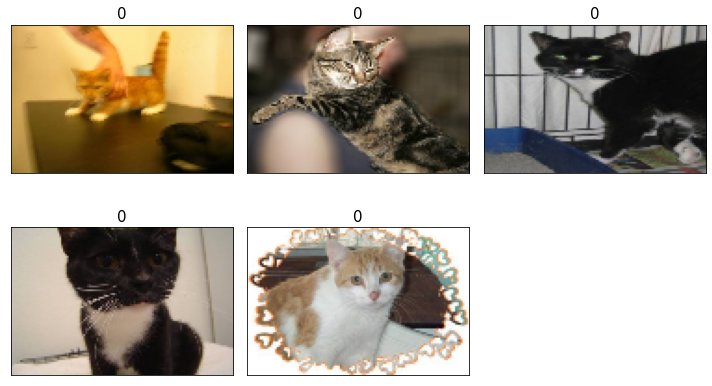

In [11]:
fig = plt.figure(figsize=(10, 6))

for i, example in enumerate(image_dataset):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0].numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=15)
    
plt.tight_layout()
plt.savefig('./12_04.pdf')
plt.show()

We can see the images with the labels.

## Convolution Operation
The fundamental difference between a densely connected layer and a convolution layer is this: Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns in the case of images, patterns found in small 2D windows of the inputs.

### This key characteristic gives convnets two interesting properties:

The patterns they learn are translation invariant. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: forexample, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location.
They can learn spatial hierarchies of patterns (see figure 5.2). A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical).


### Defining a Simple CNN in pytorch

In [43]:
import torch
from torch.optim import Adam,SGD
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout


class CNN_DG(Module):
    def __init__(self):
        super(CNN_DG, self).__init__()
        
        self.cnn_layers = Sequential(
            Conv2d(1,4,kernel_size=3,stride=1,padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2),
            Conv2d(4,4,kernel_size=3,stride=1,padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2),
        )
        
        self.linear_layers = Sequential(
            Linear(4*7*7,10)
        )
    
    def feed_forward(self,x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0),-1)
        x = self.linear_layers(x)
        return x


In [46]:
model = CNN_DG()

optimizer = Adam(model.parameters(),lr=0.007)

criterion = CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

CNN_DG(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)
